<a href="https://colab.research.google.com/github/francobarrionuevoenv21/HPC_2025/blob/main/CA_Implt_GPUs_HPC2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## NDVI DATA

In [78]:
def calculate_p_den(water_thres, low_thres, high_thres, NDVI):
    water_value = 'water'
    low_value = 'nonflammable'
    mid_value = 'medium'
    high_value = 'dense'

    # Initialize ndvi_grouped with a default value or array
    #ndvi_grouped = np.empty_like(NDVI, dtype='<U10') # Using string dtype to hold the category names

    ndvi_grouped = np.where(NDVI >= high_thres, high_value, NDVI)
    ndvi_grouped = np.where((NDVI >= low_thres) & (NDVI < high_thres), mid_value, ndvi_grouped)
    ndvi_grouped = np.where((NDVI >= water_thres) & (NDVI < low_thres), low_value, ndvi_grouped)
    # The original code had this condition last, let's keep it for water
    ndvi_grouped = np.where(NDVI < water_thres, water_value, ndvi_grouped)


    return ndvi_grouped

def calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped):
    p_den = np.zeros_like(ndvi_grouped, dtype=float)  # numeric array

    p_den[ndvi_grouped == 'water'] = den_water
    p_den[ndvi_grouped == 'nonflammable'] = den_low
    p_den[ndvi_grouped == 'medium'] = den_mid
    p_den[ndvi_grouped == 'dense'] = den_high

    return p_den

In [79]:
NDVI_random = np.random.rand(x, y)

In [81]:
ndvi= NDVI_random
water_thres = 0.1
low_thres = 0.5
high_thres = 0.7

den_water = -1 # Using negative values for water to ensure it can't be enflamed
den_low = -1 # These are nonflammable areas
den_mid = 0 # These are the general areas
den_high = 0.2 # Dense areas have increased change of spreading

# Let's group the NDVI using the first function
ndvi_grouped = calculate_p_den(water_thres, low_thres, high_thres, ndvi)

# p_den is the one that will actually be used for calculation. Not that water and nonflammable are both -1, i.e., nonflammable.
# Otherwise, the more vegetation the higher the burn probability
p_den = calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped)


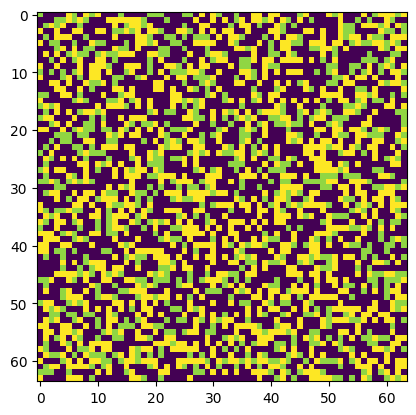

In [77]:
#cmap_123 = ListedColormap(['blue', 'goldenrod', 'limegreen', 'darkgreen'])
plt.imshow(p_den)
plt.show()

In [6]:
n_t = 3 # timesteps
x = 64
y = 64

# fire_state = lon x lat
fire_state = np.zeros((n_t, x, y), dtype=int) #fire_state = np.zeros((n_t, len(x), len(y)), dtype=int)

In [84]:
#p_burn = p_h * (1+p_den) # probability of burning
p_h = 0.6
p_burn = p_h*(1+p_den)

In [85]:
p_burn

array([[0.72, 0.72, 0.  , ..., 0.  , 0.72, 0.6 ],
       [0.  , 0.6 , 0.  , ..., 0.72, 0.72, 0.  ],
       [0.72, 0.72, 0.72, ..., 0.  , 0.72, 0.  ],
       ...,
       [0.72, 0.  , 0.72, ..., 0.72, 0.  , 0.  ],
       [0.  , 0.72, 0.72, ..., 0.72, 0.6 , 0.72],
       [0.72, 0.  , 0.  , ..., 0.72, 0.  , 0.6 ]])

In [83]:
#fire_state

In [ ]:
for i_t in range(1,n_t):
    for i in range(len(x)):
        for j in range(len(y)):
            # If cell is burnt it remains burnt
            if fire_state[i_t-1, i, j] == 2:
                fire_state[i_t, i, j] = 2
            # If cell was burning it turns into a burnt cell
            elif fire_state[i_t-1, i, j] == 1:
                fire_state[i_t, i, j] = 2
            # If cell is not burning and adjacent cell is burning, calculate if it turns to burning cell
            elif (i+1 < len(x) and fire_state[i_t-1, i+1, j] == 1) or \ # right pixel
               (i-1 >= 0 and fire_state[i_t-1, i-1, j] == 1) or \ # left pixel
               (j+1 < len(y) and fire_state[i_t-1, i, j+1] == 1) or \ # upper pixel
               (j-1 >= 0 and fire_state[i_t-1, i, j-1] == 1) or \ # lower pixel
               (i+1 < len(x) and j+1 < len(y) and fire_state[i_t-1, i+1, j+1] == 1) or \ # upper-right pixel
               (i-1 >= 0 and j-1 >= 0 and fire_state[i_t-1, i-1, j-1] == 1) or \ # lower-left pixel
               (i+1 < len(x) and j-1 >= 0 and fire_state[i_t-1, i+1, j-1] == 1) or \ # lower-right pixel
               (i-1 >= 0 and j+1 < len(y) and fire_state[i_t-1, i-1, j+1] == 1): # upper-left pixel
                if np.random.rand() < p_burn[i,j]:
                    fire_state[i_t, i, j] = 1
                else:
                    fire_state[i_t, i, j] = 0
            # All cells that are not burning and not adjacent to a burning cell remain unburnt
            else:
                fire_state[i_t, i, j] = fire_state[i_t-1, i, j]